# Exercise 3

## 1) Neural Network Classifier from Scratch (14p.)

In this exercise, we will implement a small neural network from scratch, i.e., only using numpy. This is nothing you would do "in real life" but it is a good exercise to deepen understanding. 

The network will consist of an arbitrary number of hidden layers with ReLU activation, a sigmoid output layer (as we are doing binary classification) and we will train it using the binary cross-entropy (negative Bernoulli likelihood) loss function. 

Ok, so let's start by importing and loading what we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# load our two moons (I promise we will get a new dataset in the next exercise)
two_moons_train_data = dict(np.load("two_moons.npz", allow_pickle=True)) 
two_moons_test_data = dict(np.load("two_moons_test.npz", allow_pickle=True))
# we need to reshape our labels so that they are [N, 1] and not [N] anymore
two_moons_train_samples = two_moons_train_data["samples"]
two_moons_train_labels = two_moons_train_data["labels"][:, None]
two_moons_test_samples = two_moons_test_data["samples"]
two_moons_test_labels = two_moons_test_data["labels"][:, None]

### 1.1.) Auxillary Functions (3 p.)
We start with implementing some auxiliary functions we are going to need later. The sigmoid and ReLU activation functions, the binary cross-entropy loss as well as their derivatives.

The binary cross entropy loss is given as 
$ - \dfrac{1}{N} \sum_{i=1}^N (y_i \log (p_i) + (1 - y_i) \log (1 - p_i)) $ where $y_i$ denotes the ground truth label and $p_i$ the network prediction for sample $i$.

**Hint** All derivatives were derived/implemented during the lecture or previous exercise - so feel free to borrow them from there. 

In [2]:
def relu(x: np.ndarray) -> np.ndarray:
    """
    elementwise relu activation function
    :param x: input to function [shape: arbitrary]
    :return : relu(x) [shape: same as x]
    """
    ### TODO #########################
    return np.maximum(0, x)
    ##################################


def d_relu(x: np.ndarray) -> np.ndarray:
    """
    elementwise gradient of relu activation function
    :param x: input to function [shape: arbitrary]
    :return : d relu(x) / dx [shape: same as x]
    """
    ### TODO #########################
    return (x > 0).astype(float)
    ##################################


def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    elementwise sigmoid activation function
    :param x: input to function [shape: arbitrary]
    :return : sigmoid(x) [shape: same as x]
    """
    ### TODO #########################
    return 1 / (1 + np.exp(-x))
    ##################################


def d_sigmoid(x: np.ndarray) -> np.ndarray:
    """
    elementwise sigmoid activation function
    :param x: input to function [shape: arbitrary]
    :return : d sigmoid(x) /dx [shape: same as x]
    """
    ### TODO #########################
    return sigmoid(x) * (1 - sigmoid(x))
    ##################################


def binary_cross_entropy(predictions: np.ndarray, labels: np.ndarray) -> float:
    """
    binary cross entropy loss (negative bernoulli ll)
    :param predictions: predictions by model [shape [N]]
    :param labels: class labels corresponding to train samples, [shape: [N]]
    :return binary cross entropy
    """
    ### TODO #########################
    return -(1/predictions.shape[0]) * np.sum(labels * np.log(predictions + 1e-12) + (1 - labels) * np.log(1 - predictions + 1e-12))
    ##################################


def d_binary_cross_entropy(predictions: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    gradient of the binary cross entropy loss
    :param predictions: predictions by model [shape [N]]
    :param labels: class labels corresponding to train samples, [shape [N]]
    :return gradient of binary cross entropy, w.r.t. the predictions [shape [N]]
    """
    ### TODO #########################
    return -(labels / (predictions + 1e-12) - (1 - labels) / (1 - predictions + 1e-12)) / predictions.shape[0]
    ##################################

## 1.2) Setting up the Network and Initialization (2 p.)

Next, we are going to set up the neural network. We will represent it as a list of weight matrices and a list of bias vectors. Each list has one entry for each layer.


In [3]:
def init_weights(neurons_per_hidden_layer: List[int], 
                 input_dim: int, 
                 output_dim: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    :param neurons_per_hidden_layer: list of numbers, indicating the number of neurons of each hidden layer
    :param input_dim: input dimension of the network
    :param output_dim: output dimension of the network
    :param seed: seed for random number generator
    :return list of weights and biases as specified by dimensions and hidden layer specification
    """
    # seed random number generator
    current_input_dim = input_dim
    weights = []
    biases = []

    # initialize weight and bias for each hidden layer and the output layer
    for current_output_dim in neurons_per_hidden_layer + [output_dim]:
        
        #### TODO ##################
        # Initialize the bias with zeros and the weights with the relu corrected Xavier activation 
        # You can use np.random.normal to sample from N(0, 1).
        bias = np.zeros(current_output_dim)
        weight = np.random.normal(loc=0.0, scale=np.sqrt(2.0 / current_input_dim), size=(current_input_dim, current_output_dim))
        ############################
        # append new weight and bias
        weights.append(weight)
        biases.append(bias)
        # next layer has current output dim as input dim 
        current_input_dim = current_output_dim

    return weights, biases

## 1.3) Forward Pass (3 p.)

The next step is the forward pass, i.e., propagating a batch of samples through the network to get the final prediction.
But that's not all - to compute the gradients later we also need to store all necessary quantities, here those are:
- The input to every layer (here called h's)
- The "pre-activation" of every layer, i.e., the quantity that is fed into the non-linearity (here called z's)


In [4]:
def forward_pass(x: np.ndarray, 
                 weights: List[np.ndarray],
                 biases: List[np.ndarray]) -> Tuple[np.ndarray, List[np.ndarray], List[np.ndarray]]:
    """
    propagate input through network
    :param x: input: (shape, [N x input_dim])
    :param weights: weight parameters of the layers
    :param biases: bias parameters of the layers
    :return: - Predictions of the network [shape, [N x out_put_dim]]
             - hs: output of each layer [input + all hidden layers] [length: len(weights)]
             - zs: preactivation of each layer [all hidden layers + output] [length: len(weights)]
    """

    hs = []  # list to store all inputs
    zs = []  # list to store all pre-activations
    
    # input to first hidden layer is just the input to the network 
    h = x
    hs.append(h)
    
    ### TODO #########################
    # pass trough hidden layers
    for weight, bias in zip(weights[:-1], biases[:-1]):
        z = h @ weight + bias
        zs.append(z)
        h = relu(z)
        hs.append(h)
    ##################################

    # output layer
    z = h @ weights[-1] + biases[-1]  
    zs.append(z) # store last pre-activation 
    y = sigmoid(z)

    return y, hs, zs




## 1.4) Backward Pass (4 p.)

For training by gradient descent we need - well - gradients. Those are computed using backpropagation during the so-called "backward pass". We will use the chain rule to propagate the gradient back through the network and, at every layer, compute the gradients for the weights and biases at that layer. The initial gradient is given by the gradient of the loss function w.r.t. the network output.

**Hint** recall that you can implement a bached outer product of two batches of vectors, `a` (with shape `(n, x)`) and `b` (with shape `(n,y)`) as 

`np.expand_dims(a, axis=1) * np.expand_dims(b, axis=2)`

(will have shape `(n, y, x)`)


In [5]:
def backward_pass(loss_grad: np.ndarray, 
                  hs: List[np.ndarray], 
                  zs: List[np.ndarray], 
                  weights: List[np.ndarray],
                  biases: List[np.ndarray]) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    propagate gradient backwards through network
    :param loss_grad: gradient of the loss function w.r.t. the network output [shape: [N, 1]]
    :param hs: values of all hidden layers during forward pass
    :param zs: values of all preactivations during forward pass
    :param weights: weight paramameters of the layers
    :param biases: bias parameters of the layers
    :return: d_weights: List of weight gradients - one entry with same shape for each entry of "weights"
             d_biases: List of bias gradients - one entry with same shape for each entry of "biases"
    """

    # return gradients as lists - we pre-initialize the lists as we iterate backwards
    d_weights = [None] * len(weights)
    d_biases = [None] * len(biases)

    ### TODO #########################
    delta = loss_grad * d_sigmoid(zs[-1])
    d_weights[-1] = hs[-1].T @ delta
    d_biases[-1] = np.sum(delta, axis=0)

    for l in reversed(range(len(weights) - 1)):
        dz = d_relu(zs[l]) 
        delta = (delta @ weights[l + 1].T) * dz 

        d_weights[l] = hs[l].T @ delta       
        d_biases[l] = np.sum(delta, axis=0)
    ##################################

    return d_weights, d_biases

## 1.5) Optimization (2 p.)

Finally, we are going to implement a training procedure for our neural network. We first initialize the network using the previously implemented method and then optimize it using stochastic gradient descent. For this, we extend our stochastic gradient descent implementation from the first exercise with a simple momentum term $m$, which forms a running average over the gradient $g$, i.e.,\n
$$\boldsymbol{m}_{k+1} = \gamma \boldsymbol{m}_k + (1 - \gamma) \boldsymbol{g}_k$$
where $\gamma$ denotes the constant momentum factor. We will then use $m$ instead of $g$ for the parameter updates.

In [6]:
def train_neural_net(train_samples: np.ndarray,
                     train_labels: np.ndarray,
                     test_samples: np.ndarray,
                     test_labels: np.ndarray,
                     layers: List[int],
                     learning_rate: float,
                     momentum_factor: float, 
                     num_iterations: int,
                     batch_size: int) -> Tuple[List[np.ndarray], List[np.ndarray], np.ndarray, np.ndarray]:
    """
    initialize and train the neural network, also keeps track of train and test error during training.
    :param train_samples: samples to train on [shape [N, sample_dim]]
    :param train_labels: labels corresponding to train samples, [shape [N, 1]]
    :param test_samples: samples to test on [shape [M, sample_dim]]
    :param test_labels: labels corresponding to test samples, [shape [M, 1]]
    :param layers: list of integers, indicating sizes of hidden layers
    :param learing_rate: size of optimizer update steps 
    :param momentum_factor: factor gamma to control the momentum moving average 
    :param num_iterations: total number of iterations (i.e. passes over whole dataset)
    :param batch_size: size of batches, has to evenly devide N, 1 for full stochastic gradient descent,
                       N for full batch gradient descent
    
    :return: list of trained weights, 
             list of trained biases, 
             train errors during training,
             test errors during training
    """
    
    assert 1 <= batch_size <= train_samples.shape[0]
    # This is a somewhat simplifying assumption but for the exercise its ok
    assert train_samples.shape[0] % batch_size == 0, "Batch Size does not evenly divide number of samples"
    batches_per_iter = int(train_samples.shape[0] / batch_size)

    
    # init model
    weights, biases = init_weights(layers, 
                                   input_dim=train_samples.shape[-1], 
                                   output_dim=train_labels.shape[-1])

    #book keeping
    train_losses = []
    test_losses = []

    momentum_weights = [np.zeros(w.shape) for w in weights]
    momentum_biases = [np.zeros(b.shape) for b in biases]
    for i in range(num_iterations):
        rnd_idx = np.random.permutation(train_samples.shape[0])
        for j in range(batches_per_iter):

            global_idx = i * batches_per_iter + j
            
            sample_batch = train_samples[rnd_idx[j * batch_size: (j + 1) * batch_size]]
            label_batch = train_labels[rnd_idx[j * batch_size: (j + 1) * batch_size]]
        
            # predict network outputs and record intermediate quantities using the forward pass
            prediction, hs, zs = forward_pass(sample_batch, weights, biases)
            train_losses.append(binary_cross_entropy(prediction, label_batch))

            # compute gradients
            loss_grad = d_binary_cross_entropy(prediction, label_batch)
            w_grads, b_grads = backward_pass(loss_grad, hs, zs, weights, biases)
            
            ##### TODO ####
            # update momentum terms and parameters using the previously computed gradients. 
            for l in range(len(weights)):
                momentum_weights[l] = momentum_factor * momentum_weights[l] + (1 - momentum_factor) * w_grads[l]
                weights[l] -= learning_rate * momentum_weights[l]
                
                momentum_biases[l] = momentum_factor * momentum_biases[l] + (1 - momentum_factor) * b_grads[l]
                biases[l] -= learning_rate * momentum_biases[l]
            ###############
            test_losses.append(binary_cross_entropy(forward_pass(test_samples, weights, biases)[0], test_labels))
        
    return weights, biases, train_losses, test_losses 

## Tying Everything Together 

Finally, we can tie everything together and train our network. Train and test accuarcy should be larger than 0.95. If the results do not seem to have converged yet, try increasing the num_iterations argument

Train Accuracy:  1.0
Test Accuracy:  1.0


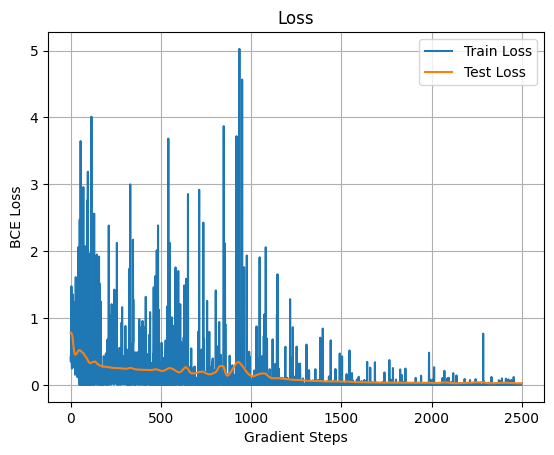

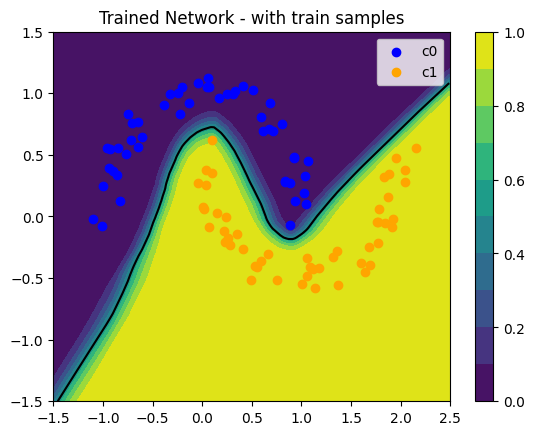

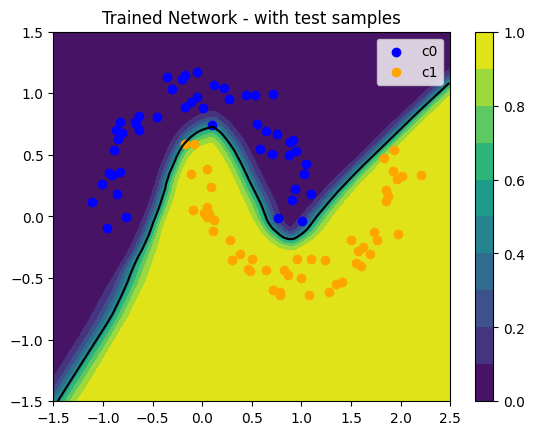

In [7]:
# seed random number generator
np.random.seed(42)

# train network
weights, biases, train_losses, test_losses = train_neural_net(train_samples=two_moons_train_samples,
                                                              train_labels=two_moons_train_labels,
                                                              test_samples=two_moons_test_samples,
                                                              test_labels=two_moons_test_labels,
                                                              learning_rate=5e-2,
                                                              num_iterations=25,
                                                              momentum_factor=0.99,
                                                              batch_size=1,
                                                              layers=[64, 64])

# plotting
plt.title("Loss")
plt.plot(train_losses)
plt.plot(test_losses)
plt.xlabel("Gradient Steps")
plt.ylabel("BCE Loss")
plt.grid("on")
plt.legend(["Train Loss", "Test Loss"])


# evaluate accuracy 
train_predictions = forward_pass(two_moons_train_samples, weights, biases)[0]
test_predictions = forward_pass(two_moons_test_samples, weights, biases)[0]

predicted_train_labels = np.ones(train_predictions.shape)
predicted_train_labels[train_predictions < 0.5] = 0
print("Train Accuracy: ", 
      np.count_nonzero(predicted_train_labels == two_moons_train_labels) / len(two_moons_train_samples))

predicted_test_labels = np.ones(test_predictions.shape)
predicted_test_labels[test_predictions < 0.5] = 0
print("Test Accuracy: ",
      np.count_nonzero(predicted_test_labels == two_moons_test_labels) / len(two_moons_test_samples))


def plt_solution(samples, labels):
    plt_range = np.arange(-1.5, 2.5, 0.01)
    plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
    plt_grid_shape = plt_grid.shape[:2]
    pred_grid = np.reshape(forward_pass(plt_grid, weights, biases)[0], plt_grid_shape)
    plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[0.5], colors=["black"])
    plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)
    plt.colorbar()
    s0 = plt.scatter(x=samples[labels[:, 0] == 0, 0], y=samples[labels[:, 0] == 0, 1],
                     label="c=0", c="blue")
    s1 = plt.scatter(x=samples[labels[:, 0] == 1, 0], y=samples[labels[:, 0] == 1, 1],
                     label="c=1", c="orange")
    plt.legend([s0, s1], ["c0", "c1"])
    plt.xlim(-1.5, 2.5)
    plt.ylim(-1.5, 1.5)


plt.figure()
plt.title("Trained Network - with train samples")
plt_solution(two_moons_train_samples, two_moons_train_labels)

plt.figure()
plt.title("Trained Network - with test samples")
plt_solution(two_moons_test_samples, two_moons_test_labels)
plt.show()


## 2.) MNIST Classifier with PyTorch (6 p.)

Modern deep learning approaches are mostly implemented using special libraries, providing functionality such as automatic differentiation, common SGD Optimiziers, easy usage of GPUs and so on. We will use PyTorch, at the moment the, arguably, most common framework (for research).

## Getting Started
You can find a documentation of the PyTorch API here https://pytorch.org/docs/stable/torch.html# . Don't worry if it seems a lot, we will point out the relevant bits during the exercise as we go along, also feel free to take another look at the tutorial notebook, some details are introduced there in more depth.

**Installation** 
You can find installation instructions here https://pytorch.org/ . Take the most recent stable version (1.10.X). We won't use GPUs here so you can take the cuda-free installation. We also don't need torchvision nor torchaudio so those don't need to be installed.

**Data**
We finally use a new dataset. The classical MNIST Handwritten Digit Classification set. It consists of grayscale images of size 28x28 of handwritten digits. Let's load it and visualize some of the images. We also do some preprocessing. 


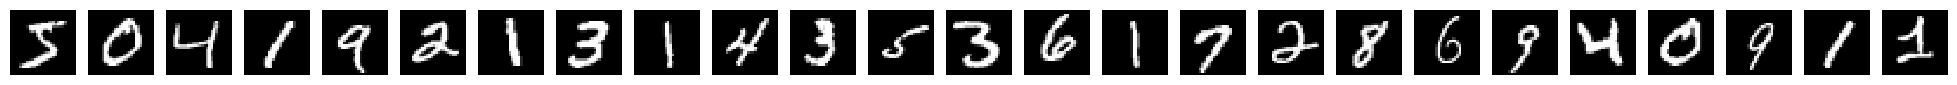

In [8]:
import torch


data_dict = dict(np.load("mnist.npz"))

# prepare data:
# - Images are casted to float 32 (from uint8) mapped in interval (0,1) and a "fake" color channel is added.
#   torch uses "NCHW"-layout for 2d convolutions. (i.e., a batch of images is represented as a 4 d tensor 
#   where the first axis (N) is the batch dimension, the second the (color) **C**hannels, followed by a **H**eight
#   and a **W**idth axis). As we have grayscale images there is only 1 color channel.  
# - targets are mapped to one hot encoding - torch does that for us 
with torch.inference_mode():
    train_samples = torch.from_numpy(data_dict["train_samples"].astype(np.float32) / 255.0).reshape(-1, 1, 28, 28)
    train_labels = torch.nn.functional.one_hot(torch.from_numpy(data_dict["train_labels"])).float()
    test_samples = torch.from_numpy(data_dict["test_samples"].astype(np.float32) / 255.0).reshape(-1, 1, 28, 28)
    test_labels = torch.nn.functional.one_hot(torch.from_numpy(data_dict["test_labels"])).float()


# plot first 25 images in train set
plt.figure(figsize=(25, 1))
for i in range(25):
    plt.subplot(1, 25, i + 1)
    # drop channel axis for plotting
    plt.imshow(train_samples[i, 0], cmap="gray", interpolation="none")
    plt.gca().axis("off")
    

## 2.1) Specifiying the Network (6 p.)

Your task here is to build a convolutional classifier for the MNIST Classification task. This classifier should consist of a convolutional part, followed by a fully connected part, see the general structure below, and also see the tutorial notebook for further details.

Designing the explicit architecture is up to you, but your classifier should reach a test set accuracy of at least 95% with the hyperparameters specified below. 

In the torch API under torch.nn you can find everything you need. Consider using some of the following classes, (you don't have to use all, you can use one multiple times) 

**Layers**
- Linear,
- Conv2d,

**Pooling** 
- MaxPool2d
- AvgPool2d 

**Activations**
- ReLU
- ELU
- Tanh
- Sigmoid
- ... (there are many more)

**Write a few sentences about how you proceeded and what you observed while trying different architectures!**

In [9]:
nn = torch.nn

def get_conv_net() -> nn.Sequential:
    return nn.Sequential(
        # input are images of shape 1 (color) x 28 (heigth) x 28 (width)
        ## TODO ##########
        # add some conv layers and pooling
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),  # (16, 28, 28)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  # (16, 14, 14)

        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),  # (32, 14, 14)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        ##################
        
        # At the transition between the conv layers and the dense layers we need to "flatten" the data, 
        # i.e. transform from a 4 d tensor (batch x dims of last set of filters) to a 2 d tensor 
        # ( batch x product(dims of last set of filters) )
        nn.Flatten(),
        ## TODO ##########
        # add some fully connected layers
        nn.Linear(in_features=16 * 7 * 7, out_features=128),
        nn.ReLU(),
        ##################
        # the last layer should have output size 10 (one entry for each class))
        nn.Linear(in_features=128, out_features=train_labels.shape[-1]),
        # the activation is "implict", i.e., we do not need to add a softmax layer. Instead 
        # the loss is computed directly using the "logits" (i.e. the values that are input to the softmax)
        # by nn.functional.cross_entropy later. This is numerically much more stable, we only need to remember to 
        # add the softmax when prediction class labels for evaluation.
    )


## Training

We that we have specified the network we can train it using the code below.

In [10]:
# training hyperparameters
num_iters = 5  # small number of epochs should be sufficient to get descent performance
batch_size = 64

# making sure this cell behaves deterministically 
torch.manual_seed(0)
np.random.seed(0)
classifier = get_conv_net()
 
# Train data set and loader, see recap notebook (or pytorch documentation for more detail on this)
train_set = torch.utils.data.TensorDataset(train_samples, train_labels)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size)

# Optimizer 
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3) 


# train loop
train_losses = []
test_losses = []
for i in range(num_iters):
    print("Iteration {:03d}".format(i + 1))
    for batch in train_loader:
        # forward pass
        samples, labels = batch
        optimizer.zero_grad()

        predictions = classifier(samples)   # predict logits
        loss = nn.functional.cross_entropy(input=predictions,
                                           target=labels)

        # backward pass
        loss.backward()
        # update step 
        optimizer.step()
        #########
        train_losses.append(loss.detach().numpy())
    
    with torch.inference_mode():      
        predictions = classifier(test_samples)
        loss = nn.functional.cross_entropy(input=predictions,
                                           target=test_labels)
        # don't forget to add the softmax when predicting the class labels ;) 
        predicted_labels = nn.functional.softmax(predictions, dim=-1).argmax(dim=-1)
        test_losses.append(loss.numpy())
        acc = torch.count_nonzero(predicted_labels == test_labels.argmax(dim=-1)) / test_labels.shape[0]
        print("Test Set Accuracy: {:.3f}, Test Loss {:.3f}".format(acc.numpy(), loss.numpy()))




Iteration 001
Test Set Accuracy: 0.968, Test Loss 0.105
Iteration 002
Test Set Accuracy: 0.979, Test Loss 0.066
Iteration 003
Test Set Accuracy: 0.983, Test Loss 0.053
Iteration 004
Test Set Accuracy: 0.983, Test Loss 0.052
Iteration 005
Test Set Accuracy: 0.991, Test Loss 0.027


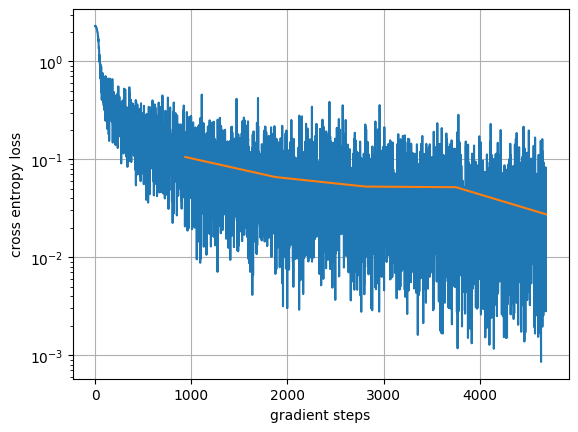

In [11]:
# plot losses
plt.figure()
num_train_batches = len(train_loader)
plt.semilogy(train_losses, label="train loss")
plt.semilogy(np.arange(num_train_batches, num_iters * num_train_batches+1, num_train_batches),
             test_losses,
             label="test_loss")
plt.xlabel("gradient steps")
plt.ylabel("cross entropy loss")
plt.grid("on")
plt.show()